SyntaxError: invalid syntax (<ipython-input-1-ec3689f7325c>, line 1)

In [1]:
try:
    import Bio
except:
    #for rhofold+ #####################
    !pip install biopython
    !pip install ml-collections
    !pip install python-box
    !pip install dm-tree
    !pip install openmm[cuda12]





from copy import deepcopy

import pandas as pd
from Bio.PDB import Atom, Model, Chain, Residue, Structure, PDBParser
from Bio import SeqIO
import os, sys
import re
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

print('IMPORT OK !!!!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 19.9 MB/s eta 0:00:00:00:010:01m
IMPORT OK !!!!


In [2]:
PYTHON = sys.executable
print('PYTHON',PYTHON)

RHONET_DIR=\
'/kaggle/input/data-for-demo-for-rhofold-plus-with-kaggle-msa/RhoFold-main'
#'<your downloaded rhofold repo>/RhoFold-main'

USALIGN = \
'/kaggle/working//USalign'
#'<your us align path>/USalign'

os.system('cp /kaggle/input/usalign/USalign /kaggle/working/')
os.system('sudo chmod u+x /kaggle/working//USalign')


DATA_KAGGLE_DIR = '/kaggle/input/stanford-rna-3d-folding'
SEQ_DF = pd.read_csv(f'{DATA_KAGGLE_DIR}/train_sequences.csv')
LABEL_DF = pd.read_csv(f'{DATA_KAGGLE_DIR}/train_labels.csv')
LABEL_DF['target_id'] = LABEL_DF['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


# helper ----
class dotdict(dict):
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

	def __getattr__(self, name):
		try:
			return self[name]
		except KeyError:
			raise AttributeError(name)

# visualisation helper ----
def set_aspect_equal(ax):
	x_limits = ax.get_xlim()
	y_limits = ax.get_ylim()
	z_limits = ax.get_zlim()

	# Compute the mean of each axis
	x_middle = np.mean(x_limits)
	y_middle = np.mean(y_limits)
	z_middle = np.mean(z_limits)

	# Compute the max range across all axes
	max_range = max(x_limits[1] - x_limits[0],
					y_limits[1] - y_limits[0],
					z_limits[1] - z_limits[0]) / 2.0

	# Set the new limits to ensure equal scaling
	ax.set_xlim(x_middle - max_range, x_middle + max_range)
	ax.set_ylim(y_middle - max_range, y_middle + max_range)
	ax.set_zlim(z_middle - max_range, z_middle + max_range)




# xyz df helper --------------------
def get_truth_df(target_id):
    truth_df = LABEL_DF[LABEL_DF['target_id'] == target_id]
    truth_df = truth_df.reset_index(drop=True)
    return truth_df

def parse_pdb_to_df(pdb_file, target_id):
    parser = PDBParser()
    structure = parser.get_structure('', pdb_file)

    df = []
    for model in structure:
        for chain in model:
            print(chain)
            chain_data = []
            for residue in chain:
                # print(residue)
                if residue.get_resname() in ['A', 'U', 'G', 'C']:
                    # Check if the residue has a C1' atom
                    if 'C1\'' in residue:
                        atom = residue['C1\'']
                        xyz = atom.get_coord()
                        resname = residue.get_resname()
                        resid = residue.get_id()[1]

                        #todo detect discontinous: resid = prev_resid+1
                        #ID	resname	resid	x_1	y_1	z_1
                        chain_data.append(dict(
                            ID = target_id+'_'+str(resid),
                            resname=resname,
                            resid=resid,
                            x_1=xyz[0],
                            y_1=xyz[1],
                            z_1=xyz[2],
                        ))
                        ##print(f"Residue {resname} {resid}, Atom: {atom.get_name()}, xyz: {xyz}")

            if len(chain_data)!=0:
                chain_df = pd.DataFrame(chain_data)
                df.append(chain_df)
                ##print(chain_df)
    return df

# usalign helper --------------------
def write_target_line(
    atom_name, atom_serial, residue_name, chain_id, residue_num, x_coord, y_coord, z_coord, occupancy=1.0, b_factor=0.0, atom_type='P'
):
    """
    Writes a single line of PDB format based on provided atom information.

    Args:
        atom_name (str): Name of the atom (e.g., "N", "CA").
        atom_serial (int): Atom serial number.
        residue_name (str): Residue name (e.g., "ALA").
        chain_id (str): Chain identifier.
        residue_num (int): Residue number.
        x_coord (float): X coordinate.
        y_coord (float): Y coordinate.
        z_coord (float): Z coordinate.
        occupancy (float, optional): Occupancy value (default: 1.0).
        b_factor (float, optional): B-factor value (default: 0.0).

    Returns:
        str: A single line of PDB string.
    """
    return f'ATOM  {atom_serial:>5d}  {atom_name:<5s} {residue_name:<3s} {residue_num:>3d}    {x_coord:>8.3f}{y_coord:>8.3f}{z_coord:>8.3f}{occupancy:>6.2f}{b_factor:>6.2f}           {atom_type}\n'

def write_xyz_to_pdb(df, pdb_file, xyz_id = 1):
    resolved_cnt = 0
    with open(pdb_file, 'w') as target_file:
        for _, row in df.iterrows():
            x_coord = row[f'x_{xyz_id}']
            y_coord = row[f'y_{xyz_id}']
            z_coord = row[f'z_{xyz_id}']

            if x_coord > -1e17 and y_coord > -1e17 and z_coord > -1e17:
                resolved_cnt += 1
                target_line = write_target_line(
                    atom_name="C1'",
                    atom_serial=int(row['resid']),
                    residue_name=row['resname'],
                    chain_id='0',
                    residue_num=int(row['resid']),
                    x_coord=x_coord,
                    y_coord=y_coord,
                    z_coord=z_coord,
                    atom_type='C',
                )
                target_file.write(target_line)
    return resolved_cnt

def parse_usalign_for_tm_score(output):
    # Extract TM-score based on length of reference structure (second)
    tm_score_match = re.findall(r'TM-score=\s+([\d.]+)', output)[1]
    if not tm_score_match:
        raise ValueError('No TM score found')
    return float(tm_score_match)

def parse_usalign_for_transform(output):
    # Locate the rotation matrix section
    matrix_lines = []
    found_matrix = False

    for line in output.splitlines():
        if "The rotation matrix to rotate Structure_1 to Structure_2" in line:
            found_matrix = True
        elif found_matrix and re.match(r'^\d+\s+[-\d.]+\s+[-\d.]+\s+[-\d.]+\s+[-\d.]+$', line):
            matrix_lines.append(line)
        elif found_matrix and not line.strip():
            break  # Stop parsing if an empty line is encountered after the matrix

    # Parse the rotation matrix values
    rotation_matrix = []
    for line in matrix_lines:
        parts = line.split()
        row_values = list(map(float, parts[1:]))  # Skip the first column (index)
        rotation_matrix.append(row_values)

    return np.array(rotation_matrix)

def call_usalign(predict_df, truth_df, verbose=1):
    truth_pdb = '~truth.pdb'
    predict_pdb = '~predict.pdb'
    write_xyz_to_pdb(predict_df, predict_pdb, xyz_id=1)
    write_xyz_to_pdb(truth_df, truth_pdb, xyz_id=1)

    command = f'{USALIGN} {predict_pdb} {truth_pdb} -atom " C1\'" -m -'
    output = os.popen(command).read()
    if verbose==1:
        print(output)
    tm_score = parse_usalign_for_tm_score(output)
    transform = parse_usalign_for_transform(output)
    return tm_score, transform


# msa helper --------------------
def read_msa(msa_file):
    f = open(msa_file, 'r')
    line = f.readlines()

    msa = []
    for i in range(0, len(line),2):
        m = dotdict(
            comment =line[i],
            seqence =line[i+1],
        )
        assert(m.comment[0]=='>')
        msa.append(m)
    return msa


def write_msa(msa_file, msa):
    line=[]
    for m in msa:
        line .append(m.comment)
        line .append(m.seqence)

    f = open(msa_file, 'wt')
    f.writelines(line)
    return msa
 
def msa_to_rhonet_file(msa_file, num_msa=5, out_dir='',target_id='xxx'):
    msa = read_msa(msa_file)
    msa0 = deepcopy(msa[0])
    msa0.comment =f'>{target_id}\n'
    msa0 = [msa0]

    a3m_file = f'{out_dir}/{target_id}.a3m'
    fasta_file = f'{out_dir}/{target_id}.fasta'
    os.makedirs(out_dir, exist_ok=True)

    write_msa(fasta_file, msa0)
    write_msa(a3m_file, msa[:num_msa])

print('HELPER OK!!!')

PYTHON /usr/bin/python3
HELPER OK!!!


In [6]:
import pandas as pd

# Load train_sequences.csv
train_sequences_path = f'{DATA_KAGGLE_DIR}/train_sequences.csv'  # Update with the correct path
df_sequences = pd.read_csv(train_sequences_path)

# Display first few rows
print(df_sequences.head())

# Extract all sequences and their corresponding IDs
rna_sequences = df_sequences["sequence"].tolist()
target_ids = df_sequences["target_id"].tolist()

print(f"Total RNA sequences loaded: {len(rna_sequences)}")


  target_id                            sequence temporal_cutoff  \
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC      1995-01-26   
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU      1995-02-27   
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU      1995-06-03   
3    1HLX_A                GGGAUAACUUCGGUUGUCCC      1995-09-15   
4    1HMH_E  GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU      1995-12-07   

                                         description  \
0               THE SARCIN-RICIN LOOP, A MODULAR RNA   
1  THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...   
2  24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...   
3  P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID   
4  THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...   

                                       all_sequences  
0  >1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...  
1  >1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...  
2  >1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...  
3  >1HLX_1|Chain A|RNA (5'-R(*GP*GP*GP*A

In [ ]:
import os
import pandas as pd
import subprocess

# Define paths
DATA_KAGGLE_DIR = "/kaggle/input/stanford-rna-3d-folding"  # Change this to your dataset path
OUTPUT_DIR = "/kaggle/working/rhofold_predictions"
MSA_DIR = f"{DATA_KAGGLE_DIR}/MSA"  # Directory where MSA files are stored
RHONET_DIR = "/kaggle/input/data-for-demo-for-rhofold-plus-with-kaggle-msa/RhoFold-main"  # Path to RhoFold repo
PYTHON = "python"  # Python command
CKPT_PATH = "/kaggle/input/data-for-demo-for-rhofold-plus-with-kaggle-msa/RhoFold-main/pretrained/model_20221010_params.pt"  # Pretrained model

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load RNA sequences
train_sequences_path = f"{DATA_KAGGLE_DIR}/train_sequences.csv"
df_sequences = pd.read_csv(train_sequences_path)

# Extract sequences and IDs
rna_sequences = df_sequences["sequence"].tolist()
target_ids = df_sequences["target_id"].tolist()

print(f"Total RNA sequences to process: {len(rna_sequences)}")

# Save each sequence as a separate FASTA file
fasta_dir = "/kaggle/working/fasta_inputs"
os.makedirs(fasta_dir, exist_ok=True)

for target_id, sequence in zip(target_ids, rna_sequences):
    fasta_path = os.path.join(fasta_dir, f"{target_id}.fasta")
    with open(fasta_path, "w") as f:
        f.write(f">{target_id}\n{sequence}\n")

print(f"✅ Saved {len(rna_sequences)} FASTA files for processing.")

# Run RhoFold+ for all FASTA files in batch mode
for target_id in target_ids:
    fasta_path = os.path.join(fasta_dir, f"{target_id}.fasta")
    msa_file = os.path.join(MSA_DIR, f"{target_id}.MSA.fasta")
    output_subdir = os.path.join(OUTPUT_DIR, target_id)
    os.makedirs(output_subdir, exist_ok=True)

    # Check if MSA file exists
    if os.path.exists(msa_file):
        print(f"🔍 Using MSA file for {target_id}")
        msa_to_rhonet_file(msa_file, num_msa=5, out_dir=OUTPUT_DIR, target_id=target_id)
        a3m_file = os.path.join(OUTPUT_DIR, f"{target_id}.a3m")
        msa_arg = f"--input_a3m {a3m_file}"
    else:
        print(f"⚠️ No MSA file found for {target_id}, proceeding without it.")
        msa_arg = ""  # No MSA input

    # Construct inference command
    cmd = (
        f"cd {RHONET_DIR}; "
        f"{PYTHON} inference.py --input_fas {fasta_path} {msa_arg} "
        f"--output_dir {output_subdir} --ckpt {CKPT_PATH}"
    )

    print(f"🚀 Running RhoFold+ for {target_id}...")
    process = subprocess.run(cmd, shell=True, capture_output=True, text=True)

    if process.returncode == 0:
        print(f"✅ Successfully processed {target_id}")
    else:
        print(f"❌ Error processing {target_id}: {process.stderr}")

print("🎯 All RNA sequences processed successfully!")


Total RNA sequences to process: 844
✅ Saved 844 FASTA files for processing.
🔍 Using MSA file for 1SCL_A
🚀 Running RhoFold+ for 1SCL_A...
✅ Successfully processed 1SCL_A
🔍 Using MSA file for 1RNK_A
🚀 Running RhoFold+ for 1RNK_A...
✅ Successfully processed 1RNK_A
🔍 Using MSA file for 1RHT_A
🚀 Running RhoFold+ for 1RHT_A...
✅ Successfully processed 1RHT_A
🔍 Using MSA file for 1HLX_A
🚀 Running RhoFold+ for 1HLX_A...
✅ Successfully processed 1HLX_A
🔍 Using MSA file for 1HMH_E
🚀 Running RhoFold+ for 1HMH_E...
✅ Successfully processed 1HMH_E
🔍 Using MSA file for 1RNG_A
🚀 Running RhoFold+ for 1RNG_A...
✅ Successfully processed 1RNG_A
🔍 Using MSA file for 1MME_D
🚀 Running RhoFold+ for 1MME_D...


In [3]:
#start here!!!


out_dir   ='/kaggle/working/'
target_id = '1EIY_C'.upper()
sequence  = 'GCCGAGGUAGCUCAGUUGGUAGAGCAUGCGACUGAAAAUCGCAGUGUCCGCGGUUCGAUUCCGCGCCUCGGCACCA'
print('len(sequence):',len(sequence))


#1. prepare input
msa_file = f'{DATA_KAGGLE_DIR}/MSA/1EIY_C.MSA.fasta'
msa_to_rhonet_file(msa_file, num_msa=5, out_dir=out_dir,target_id=target_id)

cmd1 = f'cd {RHONET_DIR}'
#cmd2 = f'export LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libstdc++.so.6' #optional if you have lib error
cmd3 = f'{PYTHON} inference.py --input_fas {out_dir}/{target_id}.fasta --input_a3m {out_dir}/{target_id}.a3m --output_dir {out_dir}/ --ckpt ./pretrained/model_20221010_params.pt'

#follow rhofold repo, we use the cmdline:
#'python inference.py --input_fas ./example/input/3owzA/3owzA.fasta --input_a3m ./example/input/3owzA/3owzA.a3m --output_dir ./example/output/3owzA/ --ckpt ./pretrained/model_20221010_params.pt'

#do inference here!
#output = os.popen(cmd1+';'+cmd2+';'+cmd3).read()
output = os.popen(cmd1+';'+cmd3).read()
print(output)

#copy file from local results
#local_result = '/kaggle/input/data-for-demo-for-rhofold-plus-with-kaggle-msa/rhofold_input_output/.'
#!cp -a $local_result $out_dir

#expected ouput from rtx A6000 (non ada)
'''
2025-03-14 20:40:50,182 - INFO: Constructing RhoFold
2025-03-14 20:40:51,221 - INFO:     loading ./pretrained/model_20221010_params.pt
2025-03-14 20:40:51,743 - INFO: Input_fas /media/hp/c30d34ed-0d55-4077-82dc-b56cd13dd548/2025/kaggle/stanford-rna-3d-folding/result/rhofold_00/1EIY_C.fasta
2025-03-14 20:40:51,743 - INFO: Input_a3m /media/hp/c30d34ed-0d55-4077-82dc-b56cd13dd548/2025/kaggle/stanford-rna-3d-folding/result/rhofold_00/1EIY_C.a3m
2025-03-14 20:40:51,743 - INFO: Started RhoFold Inference
2025-03-14 20:40:51,755 - INFO:     Inference using device cuda
2025-03-14 20:40:54,523 - INFO:     Export PDB file to /media/hp/c30d34ed-0d55-4077-82dc-b56cd13dd548/2025/kaggle/stanford-rna-3d-folding/result/rhofold_00//unrelaxed_model.pdb
2025-03-14 20:40:54,523 - INFO: Finished RhoFold Inference in 2.780 seconds
2025-03-14 20:40:54,523 - INFO: Started Amber Relaxation : 1000 iterations
2025-03-14 20:40:54,523 - INFO:     AmberRelaxation: Using OpenCL
2025-03-14 20:41:09,410 - INFO:     Minimizing ...
2025-03-14 20:42:38,203 - INFO:     Energy at Minima is -505932.780 kcal/mol
2025-03-14 20:42:38,362 - INFO:     Export PDB file to /media/hp/c30d34ed-0d55-4077-82dc-b56cd13dd548/2025/kaggle/stanford-rna-3d-folding/result/rhofold_00//relaxed_1000_model.pdb
2025-03-14 20:42:38,363 - INFO: Finished Amber Relaxation : 1000 iterations in 103.840 seconds
'''

#expected ouput from P100
'''
len(sequence): 76
2025-03-14 16:03:33,110 - INFO: Constructing RhoFold
2025-03-14 16:03:34,429 - INFO:     loading ./pretrained/model_20221010_params.pt
2025-03-14 16:03:35,088 - INFO: Input_fas /kaggle/working//1EIY_C.fasta
2025-03-14 16:03:35,089 - INFO: Input_a3m /kaggle/working//1EIY_C.a3m
2025-03-14 16:03:35,089 - INFO: Started RhoFold Inference
2025-03-14 16:03:35,093 - INFO:     Inference using device cuda
2025-03-14 16:03:40,177 - INFO:     Export PDB file to /kaggle/working///unrelaxed_model.pdb
2025-03-14 16:03:40,177 - INFO: Finished RhoFold Inference in 5.088 seconds
2025-03-14 16:03:40,177 - INFO: Started Amber Relaxation : 1000 iterations
2025-03-14 16:03:40,177 - INFO:     AmberRelaxation: Using OpenCL
2025-03-14 16:04:03,056 - INFO:     Minimizing ...
2025-03-14 16:08:49,875 - INFO:     Energy at Minima is -497896.334 kcal/mol
2025-03-14 16:08:50,044 - INFO:     Export PDB file to /kaggle/working///relaxed_1000_model.pdb
2025-03-14 16:08:50,047 - INFO: Finished Amber Relaxation : 1000 iterations in 309.869 seconds

'''

len(sequence): 76
2025-03-17 12:53:06,902 - INFO: Constructing RhoFold
2025-03-17 12:53:08,312 - INFO:     loading ./pretrained/model_20221010_params.pt
2025-03-17 12:53:12,336 - INFO: Input_fas /kaggle/working//1EIY_C.fasta
2025-03-17 12:53:12,336 - INFO: Input_a3m /kaggle/working//1EIY_C.a3m
2025-03-17 12:53:12,336 - INFO: Started RhoFold Inference
2025-03-17 12:53:12,365 - INFO:     Inference using device cuda
2025-03-17 12:53:17,478 - INFO:     Export PDB file to /kaggle/working///unrelaxed_model.pdb
2025-03-17 12:53:17,478 - INFO: Finished RhoFold Inference in 5.142 seconds
2025-03-17 12:53:17,478 - INFO: Started Amber Relaxation : 1000 iterations
2025-03-17 12:53:17,479 - INFO:     AmberRelaxation: Using OpenCL
2025-03-17 12:53:40,798 - INFO:     Minimizing ...
2025-03-17 12:58:35,343 - INFO:     Energy at Minima is -500644.680 kcal/mol
2025-03-17 12:58:35,512 - INFO:     Export PDB file to /kaggle/working///relaxed_1000_model.pdb
2025-03-17 12:58:35,514 - INFO: Finished Amber Re

'\nlen(sequence): 76\n2025-03-14 16:03:33,110 - INFO: Constructing RhoFold\n2025-03-14 16:03:34,429 - INFO:     loading ./pretrained/model_20221010_params.pt\n2025-03-14 16:03:35,088 - INFO: Input_fas /kaggle/working//1EIY_C.fasta\n2025-03-14 16:03:35,089 - INFO: Input_a3m /kaggle/working//1EIY_C.a3m\n2025-03-14 16:03:35,089 - INFO: Started RhoFold Inference\n2025-03-14 16:03:35,093 - INFO:     Inference using device cuda\n2025-03-14 16:03:40,177 - INFO:     Export PDB file to /kaggle/working///unrelaxed_model.pdb\n2025-03-14 16:03:40,177 - INFO: Finished RhoFold Inference in 5.088 seconds\n2025-03-14 16:03:40,177 - INFO: Started Amber Relaxation : 1000 iterations\n2025-03-14 16:03:40,177 - INFO:     AmberRelaxation: Using OpenCL\n2025-03-14 16:04:03,056 - INFO:     Minimizing ...\n2025-03-14 16:08:49,875 - INFO:     Energy at Minima is -497896.334 kcal/mol\n2025-03-14 16:08:50,044 - INFO:     Export PDB file to /kaggle/working///relaxed_1000_model.pdb\n2025-03-14 16:08:50,047 - INFO: 

<Chain id=A>
<Chain id=0>
           ID resname  resid        x_1        y_1        z_1
0    1EIY_C_1       G      1  12.506000  19.097000  20.490999
1    1EIY_C_2       C      2  15.018000  18.785000  15.447000
2    1EIY_C_3       C      3  16.320999  16.152000  10.681000
3    1EIY_C_4       G      4  15.793000  11.870000   7.368000
4    1EIY_C_5       A      5  13.376000   7.069000   6.330000
..        ...     ...    ...        ...        ...        ...
71  1EIY_C_72       C     72  21.424999  13.958000  17.591000
72  1EIY_C_73       A     73  20.674000  17.591000  21.313999
73  1EIY_C_74       C     74  18.847000  18.841000  26.552000
74  1EIY_C_75       C     75  18.458000  15.509000  32.235001
75  1EIY_C_76       A     76  16.905001  21.825001  35.923000

[76 rows x 6 columns]
           ID resname  resid        x_1        y_1        z_1
0    1EIY_C_1       G      1  11.974000  19.150999  20.868999
1    1EIY_C_2       C      2  14.645000  19.164000  15.545000
2    1EIY_C_3       C

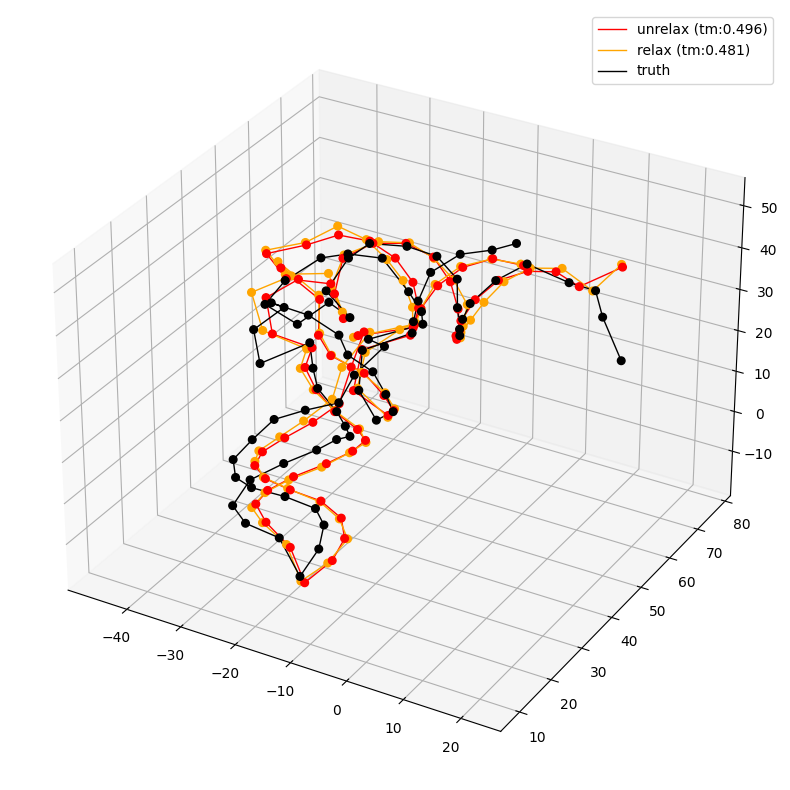

In [4]:
#visualise prediction and compute tm score

predict_relax_df = parse_pdb_to_df(f'{out_dir}/relaxed_1000_model.pdb', target_id)
predict_unrelax_df = parse_pdb_to_df(f'{out_dir}/unrelaxed_model.pdb', target_id)

assert len(predict_relax_df)==1
assert len(predict_unrelax_df)==1
predict_relax_df = predict_relax_df[0]
predict_unrelax_df = predict_unrelax_df[0]

print(predict_relax_df)
print(predict_unrelax_df)

truth_df = get_truth_df(target_id)
print(truth_df)

tm_score_relax, transform_relax = call_usalign(predict_relax_df, truth_df, verbose=1)
tm_score_unrelax, transform_unrelax= call_usalign(predict_unrelax_df, truth_df, verbose=0)

print('tm_score_relax', tm_score_relax)
print('tm_score_unrelax', tm_score_unrelax)
print('transform_relax\n', transform_relax)
print('transform_unrelax\n', transform_unrelax)
zz=0

if 1:
    COLOR = ['red', 'blue', 'green', 'black', 'yellow', 'cyan', 'magenta']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # ax.clear()

    #unrelax
    coord = predict_unrelax_df[['x_1', 'y_1', 'z_1']].to_numpy().astype('float32')
    coord = coord@transform_unrelax[:,1:].T + transform_unrelax[:,[0]].T
    x, y, z = coord[:, 0], coord[:, 1], coord[:, 2]
    ax.scatter(x, y, z, c='red', s=30, alpha=1)
    ax.plot(x, y, z, color='red', linewidth=1, alpha=1, label=f'unrelax (tm:{tm_score_unrelax:0.3f})')


    #relax
    coord = predict_relax_df[['x_1', 'y_1', 'z_1']].to_numpy().astype('float32')
    coord = coord@transform_relax[:,1:].T + transform_relax[:,[0]].T
    x, y, z = coord[:, 0], coord[:, 1], coord[:, 2]
    ax.scatter(x, y, z, c='orange', s=30, alpha=1)
    ax.plot(x, y, z, color='orange', linewidth=1, alpha=1, label=f'relax (tm:{tm_score_relax:0.3f})')

    # truth
    truth = truth_df[['x_1', 'y_1', 'z_1']].to_numpy().astype('float32')
    x, y, z = truth[:, 0], truth[:, 1], truth[:, 2]
    ax.scatter(x, y, z, c='black', s=30, alpha=1)
    ax.plot(x, y, z, color='black', linewidth=1, alpha=1, label=f'truth')

    set_aspect_equal(ax)
    plt.legend()
    plt.show()
    # plt.waitforbuttonpress()

    plt.close()
    